Кодировка метеоданных с сайта rp5.ru и почасовой прогноз расхода воды примитивной моделью с выводом распределения ошибок.

In [1]:
import numpy as np
import pandas as pd
from statsmodels.tsa.seasonal import seasonal_decompose 
# from pandas import DataFrame, Series

import matplotlib.pyplot as plt
# plotly.plotly больше не поддерживается. Нужно установить chart-studio: pip install chart_studio

# import chart_studio.plotly as py
# import plotly.graph_objs as go
# from plotly.offline import (
#     download_plotlyjs,
#     init_notebook_mode,
#     plot,
#     iplot
# )
# init_notebook_mode(connected=True)

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

tat_data = pd.ExcelFile('C:\\Users\\user_PC\\Desktop\\tatarstan\\water_consuming_pure.xlsx')

tat_data = tat_data.parse(tat_data.sheet_names[0])
# tat_data = tat_data.set_index('DATE')
tat_data.index = pd.to_datetime(tat_data.index)
massa = pd.DataFrame(tat_data['M1-M2, т'])


tat_data['DATE'] =pd.to_datetime(tat_data.DATE)
print(tat_data.head(2))
print(tat_data['DATE'].dtypes)
print(tat_data['DATE'].values.tolist()[0])

                                             DATE  W1-W2, Гкал  M1-M2, т  \
1970-01-01 00:00:00.000000000 2016-09-24 00:00:00       84.345   125.916   
1970-01-01 00:00:00.000000001 2016-09-24 01:00:00       76.151    78.791   

                               T1ср,С  T2ср,С  
1970-01-01 00:00:00.000000000  67.445  45.181  
1970-01-01 00:00:00.000000001  67.265  45.725  
datetime64[ns]
1474675200000000000


In [3]:
# с сайта rp5.ru качается таблица в формате ansi, шапка файла удаляется с сохранением заголовков колонок.
# есть какая-то чехарда в файлах, поэтому будет возня с хедером и первой строкой. не воспринимай это близко к сердцу.

    
elebuga_data = pd.read_csv('C:\\Users\\user_PC\\Desktop\\tatarstan\\elabuga_2016_2_ansi\\elabuga2.csv', delimiter = ';' , encoding = 'ansi', names=['время', 'T', 'Po', 'P', 'Pa', 'U', 'DD', 'Ff',
       'ff10', 'ff3', 'N', 'WW', 'W1', 'W2', 'Tn', 'Tx', 'Cl', 'Nh', 'H', 'Cm',
       'Ch', 'VV', 'Td', 'RRR', 'tR', 'E', 'Tg', 'E1', 'sss'])
elebuga_data = elebuga_data.drop([0], axis=0)
#сортируем 
elebuga_data['время'] =pd.to_datetime(elebuga_data.время)
elebuga_data = elebuga_data.sort_values(by='время')
elebuga_data.reset_index(drop=True, inplace=True)

# кодировка 'N'
elebuga_data.fillna(method='ffill', inplace = True)
elebuga_data.loc[(elebuga_data['N'] == 'Облаков нет.'), 'N'] = 0
elebuga_data.loc[(elebuga_data['N'] == '10%  или менее, но не 0'), 'N'] = 5
elebuga_data.loc[(elebuga_data['N'] == '20–30%.'), 'N'] = 25
elebuga_data.loc[(elebuga_data['N'] == '40%.'), 'N'] = 40
elebuga_data.loc[(elebuga_data['N'] == '50%.'), 'N'] = 50
elebuga_data.loc[(elebuga_data['N'] == '60%.'), 'N'] = 60
elebuga_data.loc[(elebuga_data['N'] == '70 – 80%.'), 'N'] = 75
elebuga_data.loc[(elebuga_data['N'] == '90  или более, но не 100%'), 'N'] = 95
elebuga_data.loc[(elebuga_data['N'] == '100%.'), 'N'] = 100
elebuga_data["N"]= elebuga_data["N"].astype(float) 

# кодировка 'WW' содержит 6 групп, каждая из которых нуждается в отдельной кодировке. 
#В раках каждой группы делается оценка в соответствии силы воздействия явления на изменение 
#температуры поверхности земли и зданий
elebuga_data.loc[elebuga_data['WW'] == ' '] = np.nan
elebuga_data[['WW']] = elebuga_data[['WW']].fillna(method='ffill')
#дожди без признаков отрицательной температуры
elebuga_data['WW1'] = elebuga_data[(elebuga_data['WW'] == 'Дымка. ') |
                                   (elebuga_data['WW'] == 'Морось незамерзающая непрерывная слабая в срок наблюдения. ') |
                                   (elebuga_data['WW'] == 'Морось незамерзающая непрерывная умеренная в срок наблюдения. ') |
                                   (elebuga_data['WW'] == 'Дождь незамерзающий с перерывами слабый в срок наблюдения. ') |
                                   (elebuga_data['WW'] == 'Дождь незамерзающий слабый. ') |
                                   (elebuga_data['WW'] == 'Дождь незамерзающий непрерывный слабый в срок наблюдения. ') |
                                   (elebuga_data['WW'] == 'Дождь незамерзающий с перерывами умеренный в срок наблюдения. ') |
                                   (elebuga_data['WW'] == 'Дождь незамерзающий непрерывный умеренный в срок наблюдения. ') |
                                   (elebuga_data['WW'] == 'Дождь (незамерзающий) неливневый. ') |
                                   (elebuga_data['WW'] == 'Дождь незамерзающий непрерывный сильный в срок наблюдения. ') |
                                   (elebuga_data['WW'] == 'Ливневый(ые) дождь(и) слабый(ые) в срок наблюдения или за последний час. ')|
                                   (elebuga_data['WW'] == 'Ливневый(ые) дождь(и). ') |
                                  (elebuga_data['WW'] == 'Ливневый(ые) дождь(и) умеренный(ые) или сильный(ые) в срок наблюдения или за последний час. ')]['WW']

elebuga_data.loc[(elebuga_data['WW1'] == 'Дымка. '), 'WW1']                                                                   = 1
elebuga_data.loc[(elebuga_data['WW1'] == 'Морось незамерзающая непрерывная слабая в срок наблюдения. '), 'WW1']               = 2
elebuga_data.loc[(elebuga_data['WW1'] == 'Морось незамерзающая непрерывная умеренная в срок наблюдения. '), 'WW1']            = 3
elebuga_data.loc[(elebuga_data['WW1'] == 'Дождь незамерзающий с перерывами слабый в срок наблюдения. '), 'WW1']               = 4
elebuga_data.loc[(elebuga_data['WW1'] == 'Дождь незамерзающий слабый. '), 'WW1']                                              = 5
elebuga_data.loc[(elebuga_data['WW1'] == 'Дождь незамерзающий непрерывный слабый в срок наблюдения. '), 'WW1']                = 6
elebuga_data.loc[(elebuga_data['WW1'] == 'Дождь незамерзающий с перерывами умеренный в срок наблюдения. '), 'WW1']            = 7
elebuga_data.loc[(elebuga_data['WW1'] == 'Дождь незамерзающий непрерывный умеренный в срок наблюдения. '), 'WW1']             = 8
elebuga_data.loc[(elebuga_data['WW1'] == 'Дождь (незамерзающий) неливневый. '), 'WW1']                                        = 9
elebuga_data.loc[(elebuga_data['WW1'] == 'Дождь незамерзающий непрерывный сильный в срок наблюдения. '), 'WW1']               = 10
elebuga_data.loc[(elebuga_data['WW1'] == 'Ливневый(ые) дождь(и) слабый(ые) в срок наблюдения или за последний час. '), 'WW1'] = 11
elebuga_data.loc[(elebuga_data['WW1'] == 'Ливневый(ые) дождь(и). '), 'WW1']                                                   = 12
elebuga_data.loc[(elebuga_data['WW1'] == 'Ливневый(ые) дождь(и) умеренный(ые) или сильный(ые) в срок наблюдения или за последний час. '), 'WW1'] = 13

elebuga_data['WW2'] = elebuga_data[(elebuga_data['WW'] == 'Гроза, но без осадков, в срок наблюдения. ') |
                                   (elebuga_data['WW'] == 'Гроза (с осадками или без них). ') |
                                   (elebuga_data['WW'] == 'Гроза слабая или умеренная без града, но с дождем и/или снегом в срок наблюдения. ')]['WW']
elebuga_data.loc[(elebuga_data['WW2'] == 'Гроза, но без осадков, в срок наблюдения. '), 'WW2']                                         = 1
elebuga_data.loc[(elebuga_data['WW2'] == 'Гроза (с осадками или без них). '), 'WW2']                                                   = 2
elebuga_data.loc[(elebuga_data['WW2'] == 'Гроза слабая или умеренная без града, но с дождем и/или снегом в срок наблюдения. '), 'WW2'] = 3
#снег
elebuga_data['WW3'] = elebuga_data[(elebuga_data['WW'] == 'Слабый или умеренный поземок в целом низкий (ниже уровня глаз наблюдателя). ') |
                                   (elebuga_data['WW'] == 'Снег непрерывный слабый в срок наблюдения.  Диаметр отложения при гололеде составляет 1 мм.') |
                                   (elebuga_data['WW'] == 'Снег непрерывный слабый в срок наблюдения. ') |
                                   (elebuga_data['WW'] == 'Снег с перерывами умеренный в срок наблюдения. ') |
                                   (elebuga_data['WW'] == 'Снег непрерывный умеренный в срок наблюдения. ') |
                                   (elebuga_data['WW'] == 'Снег неливневый. ') |
                                   (elebuga_data['WW'] == 'Снег непрерывный сильный в срок наблюдения. ')]['WW']
elebuga_data.loc[(elebuga_data['WW3'] == 'Слабый или умеренный поземок в целом низкий (ниже уровня глаз наблюдателя). '), 'WW3']                = 1
elebuga_data.loc[(elebuga_data['WW3'] == 'Снег непрерывный слабый в срок наблюдения.  Диаметр отложения при гололеде составляет 1 мм.'), 'WW3'] = 2
elebuga_data.loc[(elebuga_data['WW3'] == 'Снег непрерывный слабый в срок наблюдения. '), 'WW3']                                                 = 3
elebuga_data.loc[(elebuga_data['WW3'] == 'Снег с перерывами умеренный в срок наблюдения. '), 'WW3']                                             = 4
elebuga_data.loc[(elebuga_data['WW3'] == 'Снег непрерывный умеренный в срок наблюдения. '), 'WW3']                                              = 5
elebuga_data.loc[(elebuga_data['WW3'] == 'Снег неливневый. '), 'WW3']                                                                           = 6 
elebuga_data.loc[(elebuga_data['WW3'] == 'Снег непрерывный сильный в срок наблюдения. '), 'WW3']                                                = 7
#осадки теплее поверхности земли, т.к. есть гололед
elebuga_data['WW4'] = elebuga_data[(elebuga_data['WW'] == 'Состояние неба в общем не изменилось.  Диаметр отложения при гололеде составляет 1 мм.') |
                                   (elebuga_data['WW'] == 'Дымка.  Диаметр отложения при гололеде составляет 2 мм.') |
                                   (elebuga_data['WW'] == 'Дымка.  Диаметр отложения при гололеде составляет 3 мм.') |
                                   (elebuga_data['WW'] == 'Дождь замерзающий слабый.  Диаметр отложения при гололеде составляет 1 мм.') |
                                   (elebuga_data['WW'] == 'Дождь замерзающий слабый.  Диаметр отложения при гололеде составляет 2 мм.') |
                                   (elebuga_data['WW'] == 'Дождь незамерзающий непрерывный слабый в срок наблюдения.  Диаметр отложения при гололеде составляет 1 мм.') |
                                   (elebuga_data['WW'] == 'Дождь незамерзающий непрерывный умеренный в срок наблюдения.  Диаметр отложения при гололеде составляет 1 мм.')]['WW']
elebuga_data.loc[(elebuga_data['WW4'] == 'Состояние неба в общем не изменилось.  Диаметр отложения при гололеде составляет 1 мм.'), 'WW4']                        = 1
elebuga_data.loc[(elebuga_data['WW4'] == 'Дымка.  Диаметр отложения при гололеде составляет 2 мм.'), 'WW4']                                                       = 2
elebuga_data.loc[(elebuga_data['WW4'] == 'Дымка.  Диаметр отложения при гололеде составляет 3 мм.'), 'WW4']                                                       = 3
elebuga_data.loc[(elebuga_data['WW4'] == 'Дождь замерзающий слабый.  Диаметр отложения при гололеде составляет 1 мм.'), 'WW4']                                    = 4
elebuga_data.loc[(elebuga_data['WW4'] == 'Дождь замерзающий слабый.  Диаметр отложения при гололеде составляет 2 мм.'), 'WW4']                                    = 5
elebuga_data.loc[(elebuga_data['WW4'] == 'Дождь незамерзающий непрерывный слабый в срок наблюдения.  Диаметр отложения при гололеде составляет 1 мм.'), 'WW4']    = 6
elebuga_data.loc[(elebuga_data['WW4'] == 'Дождь незамерзающий непрерывный умеренный в срок наблюдения.  Диаметр отложения при гололеде составляет 1 мм.'), 'WW4'] = 7
elebuga_data.loc[(elebuga_data['WW4'] == 'Снег неливневый. '), 'WW4']                                                                                             = 8
#земля теплее осадков, т.к. не указан гололед
elebuga_data['WW5'] = elebuga_data[(elebuga_data['WW'] == 'Туман или ледяной туман, небо видно, ослабел за последний час. ') |
                                   (elebuga_data['WW'] == 'Туман или ледяной туман, небо видно, ослабел за последний час. ') |
                                   (elebuga_data['WW'] == 'Туман или ледяной туман, небо видно, без заметного изменения интенсивности в течение последнего часа. ') |
                                   (elebuga_data['WW'] == 'Туман или ледяной туман, неба не видно, без заметного изменения интенсивности в течение последнего часа. ') |
                                   (elebuga_data['WW'] == 'Морось (незамерзающая) или снежные зерна неливневые. ') |
                                   (elebuga_data['WW'] == 'Дождь или морось со снегом слабые. ') |
                                   (elebuga_data['WW'] == 'Дождь замерзающий слабый. ')]['WW']
elebuga_data.loc[(elebuga_data['WW5'] == 'Туман или ледяной туман, небо видно, ослабел за последний час. '), 'WW5']                                           = 1
elebuga_data.loc[(elebuga_data['WW5'] == 'Туман или ледяной туман, небо видно, без заметного изменения интенсивности в течение последнего часа. '), 'WW5']    = 2
elebuga_data.loc[(elebuga_data['WW5'] == 'Туман или ледяной туман, неба не видно, без заметного изменения интенсивности в течение последнего часа. '), 'WW5'] = 3
elebuga_data.loc[(elebuga_data['WW5'] == 'Морось (незамерзающая) или снежные зерна неливневые. '), 'WW5']                                                     = 4
elebuga_data.loc[(elebuga_data['WW5'] == 'Дождь или морось со снегом слабые. '), 'WW5']                                                                       = 5
elebuga_data.loc[(elebuga_data['WW5'] == 'Дождь замерзающий слабый. '), 'WW5']                                                                                = 6

#облака
elebuga_data['WW6'] = elebuga_data[(elebuga_data['WW'] == 'Облака в целом рассеиваются или становятся менее развитыми. ') |
                                   (elebuga_data['WW'] == 'Облака в целом образовывались или развивались. ')]['WW']
elebuga_data.loc[(elebuga_data['WW6'] == 'Облака в целом рассеиваются или становятся менее развитыми. '), 'WW6'] = 1
elebuga_data.loc[(elebuga_data['WW6'] == 'Облака в целом образовывались или развивались. '), 'WW6']              = 2
#onehot WWs
elebuga_data[['WW1']] = elebuga_data[['WW1']].fillna(0)
elebuga_data[['WW2']] = elebuga_data[['WW2']].fillna(0)
elebuga_data[['WW3']] = elebuga_data[['WW3']].fillna(0)
elebuga_data[['WW4']] = elebuga_data[['WW4']].fillna(0)
elebuga_data[['WW5']] = elebuga_data[['WW5']].fillna(0)
elebuga_data[['WW6']] = elebuga_data[['WW6']].fillna(0)

elebuga_data["WW1"]= elebuga_data["WW1"].astype(float) 
elebuga_data["WW2"]= elebuga_data["WW2"].astype(float) 
elebuga_data["WW3"]= elebuga_data["WW3"].astype(float) 
elebuga_data["WW4"]= elebuga_data["WW4"].astype(float) 
elebuga_data["WW5"]= elebuga_data["WW5"].astype(float) 
elebuga_data["WW6"]= elebuga_data["WW6"].astype(float) 

#  Сl слоистые и кучевые
elebuga_data[['Cl']] = elebuga_data[['Cl']].fillna(method='ffill')
elebuga_data.loc[(elebuga_data['Cl'] == 'Слоисто-кучевых, слоистых, кучевых или кучево-дождевых облаков нет.'), 'Cl'] = 1
elebuga_data.loc[(elebuga_data['Cl'] == 'Слоистые туманообразные или слоистые разорванные, либо те и другие, но не относящиеся к облакам плохой погоды.'), 'Cl'] = 2
elebuga_data.loc[(elebuga_data['Cl'] == 'Слоисто-кучевые, образовавшиеся не из кучевых.'), 'Cl'] = 3
elebuga_data.loc[(elebuga_data['Cl'] == 'Слоисто-кучевые, образовавшиеся из кучевых.'), 'Cl'] = 4
elebuga_data.loc[(elebuga_data['Cl'] == 'Кучевые и слоисто-кучевые (но не слоисто-кучевые, образовавшиеся из кучевых), основания расположены на разных уровнях.'), 'Cl'] = 5
elebuga_data.loc[(elebuga_data['Cl'] == 'Кучевые плоские или кучевые разорванные, или те и другие вместе, не относящиеся к облакам плохой погоды.'), 'Cl'] = 6
elebuga_data.loc[(elebuga_data['Cl'] == 'Кучевые средние или мощные или вместе с кучевыми разорванными, или с кучевыми плоскими, или со слоисто-кучевыми, либо без них; основания всех этих облаков расположены на одном уровне.'), 'Cl'] = 7
elebuga_data.loc[(elebuga_data['Cl'] == 'Кучево-дождевые лысые с кучевыми, слоисто-кучевыми или слоистыми, либо без них.'), 'Cl'] = 8
elebuga_data.loc[(elebuga_data['Cl'] == 'Кучево-дождевые волокнистые (часто с наковальней), либо с кучево-дождевыми лысыми, кучевыми, слоистыми, разорванно-дождевыми, либо без них.'), 'Cl'] = 9
elebuga_data["Cl"]= elebuga_data["Cl"].astype(float)
# облака Сh перистые
elebuga_data[['Ch']] = elebuga_data[['Ch']].fillna(method='ffill')
elebuga_data.loc[(elebuga_data['Ch'] == 'Перистых, перисто-кучевых или перисто-слоистых нет.'), 'Ch'] = 1
elebuga_data.loc[(elebuga_data['Ch'] == 'Перистые нитевидные, иногда когтевидные, не распространяющиеся по небу.'), 'Ch'] = 2
elebuga_data.loc[(elebuga_data['Ch'] == 'Перистые когтевидные или нитевидные или первые и вторые, распространяющиеся по небу и в целом обычно уплотняющиеся.'), 'Ch'] = 3
elebuga_data.loc[(elebuga_data['Ch'] == 'Перистые (часто в виде полос) и перисто-слоистые, распространяющиеся по небу и в целом обычно уплотняющиеся, но сплошная пелена поднимается над горизонтом менее чем на 45°.'), 'Ch'] = 4
elebuga_data.loc[(elebuga_data['Ch'] == 'Перистые (часто в виде полос) и перисто-слоистые, распространяющиеся по небу и в целом обычно уплотняющиеся; сплошная пелена, поднимающаяся над горизонтом выше 45°, не покрывает всего неба.'), 'Ch'] = 5
elebuga_data.loc[(elebuga_data['Ch'] == 'Перистые плотные в виде клочьев или скрученных склонов, количество которых обычно не увеличивается, иногда могут казаться остатками верхней части кучево-дождевых; или перистые башенкообразные, или перистые хлопьевидные.'), 'Ch'] = 6
elebuga_data.loc[(elebuga_data['Ch'] == 'Перистые плотные, образовавшиеся от кучево-дождевых.'), 'Ch'] = 7
elebuga_data.loc[(elebuga_data['Ch'] == 'Перисто-кучевые одни или перисто-кучевые, сопровождаемые перистыми или перисто-слоистыми, либо те и другие, но перисто-кучевые преобладают среди них.'), 'Ch'] = 8
elebuga_data["Ch"]= elebuga_data["Ch"].astype(float)
# облака Сm высококучевые
elebuga_data[['Cm']] = elebuga_data[['Cm']].fillna(method='ffill')
elebuga_data.loc[(elebuga_data['Cm'] == 'Высококучевых, высокослоистых или слоисто-дождевых облаков нет.'), 'Cm'] = 1
elebuga_data.loc[(elebuga_data['Cm'] == 'Клочья (часто чечевицеобразные) высококучевых просвечивающих, непрерывно изменяющихся; расположены на одном или более уровнях.'), 'Cm'] = 2
elebuga_data.loc[(elebuga_data['Cm'] == 'Высококучевые просвечивающие, расположенные на одном уровне.'), 'Cm'] = 3
elebuga_data.loc[(elebuga_data['Cm'] == 'Высококучевые просвечивающие, полосами, либо один или несколько слоев высококучевых просвечивающих, распространяющихся по небу; эти высококучевые в целом уплотняются.'), 'Cm'] = 4
elebuga_data.loc[(elebuga_data['Cm'] == 'Высококучевые башенкообразные или хлопьевидные.'), 'Cm'] = 5
elebuga_data.loc[(elebuga_data['Cm'] == 'Высококучевые при хаотическом виде неба, обычно расположенные на нескольких уровнях.'), 'Cm'] = 6
elebuga_data.loc[(elebuga_data['Cm'] == 'Высококучевые, просвечивающие или плотные в двух или более слоях или высококучевые плотные в одном слое, не распространяющиеся но небу, либо высококучевые с высокослоистыми или слоисто-дождевыми.'), 'Cm'] = 7
elebuga_data.loc[(elebuga_data['Cm'] == 'Высококучевые, образовавшиеся из кучевых (или кучево-дождевых).'), 'Cm'] = 8
elebuga_data.loc[(elebuga_data['Cm'] == 'Высокослоистые просвечивающие.'), 'Cm'] = 9
elebuga_data.loc[(elebuga_data['Cm'] == 'Высокослоистые непросвечивающие или слоисто-дождевые.'), 'Cm'] = 10
elebuga_data["Cm"]= elebuga_data["Cm"].astype(float) 
# VV
elebuga_data[['VV']] = elebuga_data[['VV']].fillna(method='ffill')
elebuga_data["VV"]= elebuga_data["VV"].astype(float) 

# Td
elebuga_data[['Td']] = elebuga_data[['Td']].fillna(method='ffill')
elebuga_data["Td"]= elebuga_data["Td"].astype(float) 

# E1 слой снега в роли теплоизоляции
elebuga_data[['E1']] = elebuga_data[['E1']].fillna(method='ffill')
elebuga_data.loc[(elebuga_data['E1'] == 'Поверхность почвы преимущественно покрыта льдом.'), 'E1'] = 1
elebuga_data.loc[(elebuga_data['E1'] == 'Слежавшийся или мокрый снег (со льдом или без него), покрывающий менее половины поверхности почвы.'), 'E1'] = 2
elebuga_data.loc[(elebuga_data['E1'] == 'Слежавшийся или мокрый снег (со льдом или без него), покрывающий по крайней мере половину поверхности почвы, но почва не покрыта полностью.'), 'E1'] = 3
elebuga_data.loc[(elebuga_data['E1'] == 'Неровный слой слежавшегося или мокрого снега покрывает почву полностью.'), 'E1'] = 4
elebuga_data.loc[(elebuga_data['E1'] == 'Ровный слой слежавшегося или мокрого снега покрывает поверхность почвы полностью.'), 'E1'] = 5
elebuga_data.loc[(elebuga_data['E1'] == 'Сухой рассыпчатый снег покрывает меньше половины поверхности почвы.'), 'E1'] = 6
elebuga_data.loc[(elebuga_data['E1'] == 'Сухой рассыпчатый снег покрывает по крайней мере половину поверхности почвы (но не полностью).'), 'E1'] = 7
elebuga_data.loc[(elebuga_data['E1'] == 'Неровный слой сухого рассыпчатого снега покрывает поверхность почвы полностью.'), 'E1'] = 8
elebuga_data.loc[(elebuga_data['E1'] == 'Ровный слой сухого рассыпчатого снега покрывает поверхность почвы полностью.'), 'E1'] = 9
elebuga_data["E1"]= elebuga_data["E1"].astype(float)
# E влажность поверхности почвы
elebuga_data[['E']] = elebuga_data[['E']].fillna(method='ffill')
elebuga_data.loc[(elebuga_data['E'] == 'Cухая (без трещин, заметного количества пыли или сыпучего песка)'), 'E'] = 1
elebuga_data.loc[(elebuga_data['E'] == 'Поверхность почвы влажная.'), 'E'] = 2
elebuga_data.loc[(elebuga_data['E'] == 'Поверхность почвы сырая (вода застаивается на поверхности и образует малые или большие лужи).'), 'E'] = 3
elebuga_data.loc[(elebuga_data['E'] == 'Поверхность почвы замерзшая.'), 'E'] = 4
# sss
elebuga_data[['sss']] = elebuga_data[['sss']].fillna(method='ffill')
elebuga_data.loc[(elebuga_data['sss'] == 'Менее 0.5'), 'sss'] = 0.4
elebuga_data.loc[(elebuga_data['sss'] == 'Измерение невозможно или неточно.'), 'sss'] = 0.1
elebuga_data.loc[(elebuga_data['sss'] == 'Снежный покров не постоянный.'), 'sss'] = 0.25
elebuga_data["sss"]= elebuga_data["sss"].astype(float) 
# T
elebuga_data[['T']] = elebuga_data[['T']].fillna(method='ffill')
elebuga_data["T"]= elebuga_data["T"].astype(float) 
# Tg
elebuga_data[['Tg']] = elebuga_data[['Tg']].fillna(method='ffill')
elebuga_data["Tg"]= elebuga_data["Tg"].astype(float) 
# Tx
elebuga_data[['Tx']] = elebuga_data[['Tx']].fillna(method='ffill')
elebuga_data["Tx"]= elebuga_data["Tx"].astype(float) 
# Tn
elebuga_data[['Tn']] = elebuga_data[['Tn']].fillna(method='ffill')
elebuga_data["Tn"]= elebuga_data["Tn"].astype(float) 
# # tR
# elebuga_data[['tR']] = elebuga_data[['tR']].fillna(method='ffill')
# elebuga_data["tR"]= elebuga_data["tR"].astype(float)
# E
elebuga_data[['E']] = elebuga_data[['E']].fillna(method='ffill')
elebuga_data["E"]= elebuga_data["E"].astype(float) 
# Nh процент облаков в небе
elebuga_data[['Nh']] = elebuga_data[['Nh']].fillna(method='ffill')
elebuga_data.loc[(elebuga_data['Nh'] == 'Облаков нет.'), 'Nh'] = 1
elebuga_data.loc[(elebuga_data['Nh'] == '20–30%.'), 'Nh'] = 25
elebuga_data.loc[(elebuga_data['Nh'] == '40%.'), 'Nh'] = 40
elebuga_data.loc[(elebuga_data['Nh'] == '50%.'), 'Nh'] = 50
elebuga_data.loc[(elebuga_data['Nh'] == '60%.'), 'Nh'] = 60
elebuga_data.loc[(elebuga_data['Nh'] == '70 – 80%.'), 'Nh'] = 75
elebuga_data.loc[(elebuga_data['Nh'] == '90  или более, но не 100%'), 'Nh'] = 95
elebuga_data.loc[(elebuga_data['Nh'] == '100%.'), 'Nh'] = 100
elebuga_data["Nh"]= elebuga_data["Nh"].astype(float) 
# Po
elebuga_data[['Po']] = elebuga_data[['Po']].fillna(method='ffill')
elebuga_data["Po"]= elebuga_data["Po"].astype(float) 
# P
elebuga_data[['P']] = elebuga_data[['P']].fillna(method='ffill')
elebuga_data["P"]= elebuga_data["P"].astype(float) 
# Pa
elebuga_data[['Pa']] = elebuga_data[['Pa']].fillna(method='ffill')
elebuga_data["Pa"]= elebuga_data["Pa"].astype(float) 
# # U
elebuga_data[['U']] = elebuga_data[['U']].fillna(method='ffill')
elebuga_data["U"]= elebuga_data["U"].astype(float) 
# DD направление ветра
elebuga_data[['DD']] = elebuga_data[['DD']].fillna(method='ffill')
elebuga_data[['veter_vert']] = elebuga_data[['DD']]
elebuga_data[['veter_horizon']] = elebuga_data[['DD']]
elebuga_data.loc[(elebuga_data['veter_vert'] == 'Штиль, безветрие'), 'veter_vert'] = 0
elebuga_data.loc[(elebuga_data['veter_horizon'] == 'Штиль, безветрие'), 'veter_horizon'] = 0
elebuga_data.loc[(elebuga_data['veter_vert'] == 'Ветер, дующий с юго-юго-востока'), 'veter_vert'] = 0.87
elebuga_data.loc[(elebuga_data['veter_horizon'] == 'Ветер, дующий с юго-юго-востока'), 'veter_horizon'] = 0.5
elebuga_data.loc[(elebuga_data['veter_vert'] == 'Ветер, дующий с юго-юго-запада'), 'veter_vert'] = 0.87
elebuga_data.loc[(elebuga_data['veter_horizon'] == 'Ветер, дующий с юго-юго-запада'), 'veter_horizon'] = -0.5
elebuga_data.loc[(elebuga_data['veter_vert'] == 'Ветер, дующий с юго-запада'), 'veter_vert'] = 0.71
elebuga_data.loc[(elebuga_data['veter_horizon'] == 'Ветер, дующий с юго-запада'), 'veter_horizon'] = -0.71
elebuga_data.loc[(elebuga_data['veter_vert'] == 'Ветер, дующий с западо-юго-запада'), 'veter_vert'] = 0.5
elebuga_data.loc[(elebuga_data['veter_horizon'] == 'Ветер, дующий с западо-юго-запада'), 'veter_horizon'] = -0.87
elebuga_data.loc[(elebuga_data['veter_vert'] == 'Ветер, дующий с запада'), 'veter_vert'] = 0
elebuga_data.loc[(elebuga_data['veter_horizon'] == 'Ветер, дующий с запада'), 'veter_horizon'] = -1
elebuga_data.loc[(elebuga_data['veter_vert'] == 'Ветер, дующий с севера'), 'veter_vert'] = -1
elebuga_data.loc[(elebuga_data['veter_horizon'] == 'Ветер, дующий с севера'), 'veter_horizon'] = 0
elebuga_data.loc[(elebuga_data['veter_vert'] == 'Ветер, дующий с северо-северо-запада'), 'veter_vert'] = -0.87
elebuga_data.loc[(elebuga_data['veter_horizon'] == 'Ветер, дующий с северо-северо-запада'), 'veter_horizon'] = -0.5
elebuga_data.loc[(elebuga_data['veter_vert'] == 'Ветер, дующий с северо-запада'), 'veter_vert'] = -0.71
elebuga_data.loc[(elebuga_data['veter_horizon'] == 'Ветер, дующий с северо-запада'), 'veter_horizon'] = -0.71
elebuga_data.loc[(elebuga_data['veter_vert'] == 'Ветер, дующий с юга'), 'veter_vert'] = 1
elebuga_data.loc[(elebuga_data['veter_horizon'] == 'Ветер, дующий с юга'), 'veter_horizon'] = 0
elebuga_data.loc[(elebuga_data['veter_vert'] == 'Ветер, дующий с западо-северо-запада'), 'veter_vert'] = -0.5
elebuga_data.loc[(elebuga_data['veter_horizon'] == 'Ветер, дующий с западо-северо-запада'), 'veter_horizon'] = -0.87
elebuga_data.loc[(elebuga_data['veter_vert'] == 'Ветер, дующий с юго-востока'), 'veter_vert'] = 0.71
elebuga_data.loc[(elebuga_data['veter_horizon'] == 'Ветер, дующий с юго-востока'), 'veter_horizon'] = 0.71
elebuga_data.loc[(elebuga_data['veter_vert'] == 'Ветер, дующий с востоко-юго-востока'), 'veter_vert'] = 0.5
elebuga_data.loc[(elebuga_data['veter_horizon'] == 'Ветер, дующий с востоко-юго-востока'), 'veter_horizon'] = 0.87
elebuga_data.loc[(elebuga_data['veter_vert'] == 'Ветер, дующий с востока'), 'veter_vert'] = 0
elebuga_data.loc[(elebuga_data['veter_horizon'] == 'Ветер, дующий с востока'), 'veter_horizon'] = 1
elebuga_data.loc[(elebuga_data['veter_vert'] == 'Ветер, дующий с востоко-северо-востока'), 'veter_vert'] = -0.5
elebuga_data.loc[(elebuga_data['veter_horizon'] == 'Ветер, дующий с востоко-северо-востока'), 'veter_horizon'] = 0.87
elebuga_data.loc[(elebuga_data['veter_vert'] == 'Ветер, дующий с северо-востока'), 'veter_vert'] = -0.71
elebuga_data.loc[(elebuga_data['veter_horizon'] == 'Ветер, дующий с северо-востока'), 'veter_horizon'] = 0.71
elebuga_data.loc[(elebuga_data['veter_vert'] == 'Ветер, дующий с северо-северо-востока'), 'veter_vert'] = -0.87
elebuga_data.loc[(elebuga_data['veter_horizon'] == 'Ветер, дующий с северо-северо-востока'), 'veter_horizon'] = 0.5
elebuga_data["veter_vert"]= elebuga_data["veter_vert"].astype(float)
elebuga_data["veter_horizon"]= elebuga_data["veter_horizon"].astype(float)
# ff10
elebuga_data["ff10"]= elebuga_data["ff10"].astype(float) 
elebuga_data[['ff10']] = elebuga_data[['ff10']].fillna(method='ffill')
# ff3
elebuga_data["ff3"]= elebuga_data["ff3"].astype(float) 
elebuga_data[['ff3']] = elebuga_data[['ff3']].fillna(method='ffill')
# Ff
elebuga_data["Ff"]= elebuga_data["Ff"].astype(float) 
elebuga_data[['Ff']] = elebuga_data[['Ff']].fillna(method='ffill')
# H
elebuga_data[['H']] = elebuga_data[['H']].fillna(method='ffill')
elebuga_data.loc[(elebuga_data['H'] == '2500 или более, или облаков нет.'), 'H'] = 2.50
elebuga_data.loc[(elebuga_data['H'] == '300-600'), 'H'] = 0.45
elebuga_data.loc[(elebuga_data['H'] == '1000-1500'), 'H'] = 1.25
elebuga_data.loc[(elebuga_data['H'] == '600-1000'), 'H'] = 0.80
elebuga_data.loc[(elebuga_data['H'] == '1500-2000'), 'H'] = 1.75
elebuga_data["H"]= elebuga_data["H"].astype(float)
# RRR
elebuga_data[['RRR']] = elebuga_data[['RRR']].fillna(method='ffill')
elebuga_data.loc[(elebuga_data['RRR'] == 'Осадков нет'), 'RRR'] = 0.01
elebuga_data.loc[(elebuga_data['RRR'] == 'Следы осадков'), 'RRR'] = 0.1
elebuga_data["RRR"]= elebuga_data["RRR"].astype(float)
#  W1 #тип осадков
elebuga_data[['W1']] = elebuga_data[['W1']].fillna(method='ffill')
elebuga_data.loc[(elebuga_data['W1'] == 'Облака покрывали половину неба или менее в течение всего соответствующего периода.'), 'W1'] = 1
elebuga_data.loc[(elebuga_data['W1'] == 'Облака покрывали более половины неба в течение одной части соответствующего периода и половину или менее в течение другой части периода.'), 'W1'] = 2
elebuga_data.loc[(elebuga_data['W1'] == 'Облака покрывали более половины неба в течение всего соответствующего периода.'), 'W1'] = 3
elebuga_data.loc[(elebuga_data['W1'] == 'Туман или ледяной туман или сильная мгла.'), 'W1'] = 4
elebuga_data.loc[(elebuga_data['W1'] == 'Морось.'), 'W1'] = 5
elebuga_data.loc[(elebuga_data['W1'] == 'Гроза (грозы) с осадками или без них.'), 'W1'] = 6
elebuga_data.loc[(elebuga_data['W1'] == 'Дождь.'), 'W1'] = 7
elebuga_data.loc[(elebuga_data['W1'] == 'Ливень (ливни).'), 'W1'] = 8
elebuga_data.loc[(elebuga_data['W1'] == 'Дождь со снегом или другими видами твердых осадков'), 'W1'] = 9
elebuga_data.loc[(elebuga_data['W1'] == 'Снег и/или другие виды твердых осадков'), 'W1'] = 10
elebuga_data.loc[(elebuga_data['W1'] == 'Метель'), 'W1'] = 11

# W2 # тип осадков
elebuga_data[['W2']] = elebuga_data[['W2']].fillna(method='ffill')
elebuga_data.loc[(elebuga_data['W2'] == 'Облака покрывали половину неба или менее в течение всего соответствующего периода.'), 'W2'] = 1
elebuga_data.loc[(elebuga_data['W2'] == 'Облака покрывали более половины неба в течение одной части соответствующего периода и половину или менее в течение другой части периода.'), 'W2'] = 2
elebuga_data.loc[(elebuga_data['W2'] == 'Облака покрывали более половины неба в течение всего соответствующего периода.'), 'W2'] = 3
elebuga_data.loc[(elebuga_data['W2'] == 'Явление, связанное с переносом ветром твердых частиц, видимость пониженная.'), 'W2'] = 3.5
elebuga_data.loc[(elebuga_data['W2'] == 'Туман или ледяной туман или сильная мгла.'), 'W2'] = 4
elebuga_data.loc[(elebuga_data['W2'] == 'Морось.'), 'W2'] = 5
elebuga_data.loc[(elebuga_data['W2'] == 'Гроза (грозы) с осадками или без них.'), 'W2'] =6
elebuga_data.loc[(elebuga_data['W2'] == 'Дождь.'), 'W2'] = 7
elebuga_data.loc[(elebuga_data['W2'] == 'Ливень (ливни).'), 'W2'] = 8
elebuga_data.loc[(elebuga_data['W2'] == 'Дождь со снегом или другими видами твердых осадков'), 'W2'] = 9
elebuga_data.loc[(elebuga_data['W2'] == 'Снег и/или другие виды твердых осадков'), 'W2'] = 10
elebuga_data.loc[(elebuga_data['W2'] == 'Метель'), 'W2'] = 11
elebuga_data.loc[(elebuga_data['W2'] == 'Буря'), 'W2'] = 12


elebuga_data.drop(columns=['WW', 'DD', 'tR'], inplace=True)


elebuga_data.dropna(inplace=True)


print(elebuga_data.info())
print(elebuga_data['W2'].unique())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1412 entries, 127 to 5771
Data columns (total 34 columns):
время            1412 non-null datetime64[ns]
T                1412 non-null float64
Po               1412 non-null float64
P                1412 non-null float64
Pa               1412 non-null float64
U                1412 non-null float64
Ff               1412 non-null float64
ff10             1412 non-null float64
ff3              1412 non-null float64
N                1412 non-null float64
W1               1412 non-null object
W2               1412 non-null object
Tn               1412 non-null float64
Tx               1412 non-null float64
Cl               1412 non-null float64
Nh               1412 non-null float64
H                1412 non-null float64
Cm               1412 non-null float64
Ch               1412 non-null float64
VV               1412 non-null float64
Td               1412 non-null float64
RRR              1412 non-null float64
E                1412 non-nu

In [4]:
result = pd.merge(tat_data, elebuga_data, left_on = 'DATE', right_on = 'время', how = 'left')
result.fillna(method='pad', inplace=True)
result.drop(columns=['время'], inplace=True)
result.dropna(inplace=True)

result['hour'] = pd.to_datetime(result['DATE']).dt.hour
result['dayofweek'] = pd.to_datetime(result['DATE']).dt.dayofweek
result['month'] = pd.to_datetime(result['DATE']).dt.month
result.drop(columns=['DATE'], inplace=True)
print(result.head(2))

     W1-W2, Гкал  M1-M2, т  T1ср,С  T2ср,С    T     Po      P   Pa     U   Ff  \
402      268.045   371.525  71.932  40.475  4.0  760.3  768.7  0.3  78.0  3.0   
403      272.943   413.360  71.823  40.341  4.0  760.3  768.7  0.3  78.0  3.0   

     ...  WW2  WW3  WW4  WW5  WW6  veter_vert  veter_horizon  hour  dayofweek  \
402  ...  0.0  0.0  0.0  0.0  0.0       -0.87           -0.5    18          0   
403  ...  0.0  0.0  0.0  0.0  0.0       -0.87           -0.5    19          0   

     month  
402     10  
403     10  

[2 rows x 40 columns]


In [ ]:
result.drop(result.tail(1).index,inplace=True)

result['Y_last_hour'] = result['M1-M2, т'].shift(1)
result['Y_last_24hour'] = result['M1-M2, т'].shift(24)
result.rename(columns={"M1-M2, т": "Y", "T1ср,С": "T1С", "T2ср,С": "T2С"}, inplace = True)

result.drop(columns=['W1-W2, Гкал'], inplace=True)
normalized_X_df=(result-result.min())/(result.max()-result.min())
#print(Y_df.info())
print(normalized_X_df['Y'])
print(normalized_X_df.columns)

402      0.309898
403      0.345038
404      0.377520
405      0.390795
406      0.294197
           ...   
15341    0.655771
15342    0.389370
15343    0.376730
15344    0.333331
15345    0.307619
Name: Y, Length: 14944, dtype: float64
Index(['Y', 'T1С', 'T2С', 'T', 'Po', 'P', 'Pa', 'U', 'Ff', 'ff10', 'ff3', 'N',
       'W1', 'W2', 'Tn', 'Tx', 'Cl', 'Nh', 'H', 'Cm', 'Ch', 'VV', 'Td', 'RRR',
       'E', 'Tg', 'E1', 'sss', 'WW1', 'WW2', 'WW3', 'WW4', 'WW5', 'WW6',
       'veter_vert', 'veter_horizon', 'hour', 'dayofweek', 'month',
       'Y_last_hour', 'Y_last_24hour'],
      dtype='object')


In [ ]:
result.dropna(inplace=True)
result.head()

,Y,T1С,T2С,T,Po,P,Pa,U,Ff,ff10,...,WW4,WW5,WW6,veter_vert,veter_horizon,hour,dayofweek,month,Y_last_hour,Y_last_24hour
426,378.709,71.909,41.175,4.0,760.3,768.7,0.3,78.0,3.0,11.0,...,0.0,0.0,0.0,-0.87,-0.5,18,1,10,303.731,371.525
427,427.341,71.680,41.007,4.0,760.3,768.7,0.3,78.0,3.0,11.0,...,0.0,0.0,0.0,-0.87,-0.5,19,1,10,378.709,413.360
428,463.272,71.544,40.664,4.0,760.3,768.7,0.3,78.0,3.0,11.0,...,0.0,0.0,0.0,-0.87,-0.5,20,1,10,427.341,452.031
429,485.936,71.704,40.380,4.0,760.3,768.7,0.3,78.0,3.0,11.0,...,0.0,0.0,0.0,-0.87,-0.5,21,1,10,463.272,467.835
430,358.907,71.898,40.859,4.0,760.3,768.7,0.3,78.0,3.0,11.0,...,0.0,0.0,0.0,-0.87,-0.5,22,1,10,485.936,352.833


Посмотрим, насколько справляется линейный метод регрессии в описании расхода текущими данными температуры, давления, облачности и т.д. с учетом расхода за пред час.

C:\Users\user_PC\AppData\Roaming\Python\Python37\site-packages\statsmodels\compat\pandas.py:23: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  data_klasses = (pandas.Series, pandas.DataFrame, pandas.Panel)


                            OLS Regression Results                            
Dep. Variable:                      Y   R-squared:                       0.901
Model:                            OLS   Adj. R-squared:                  0.901
Method:                 Least Squares   F-statistic:                     3393.
Date:                Fri, 08 Nov 2019   Prob (F-statistic):               0.00
Time:                        23:50:50   Log-Likelihood:                 27726.
No. Observations:               14920   AIC:                        -5.537e+04
Df Residuals:                   14879   BIC:                        -5.506e+04
Df Model:                          40                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         0.0079      0.015      0.526

C:\Users\user_PC\AppData\Roaming\Python\Python37\site-packages\pandas\core\series.py:853: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


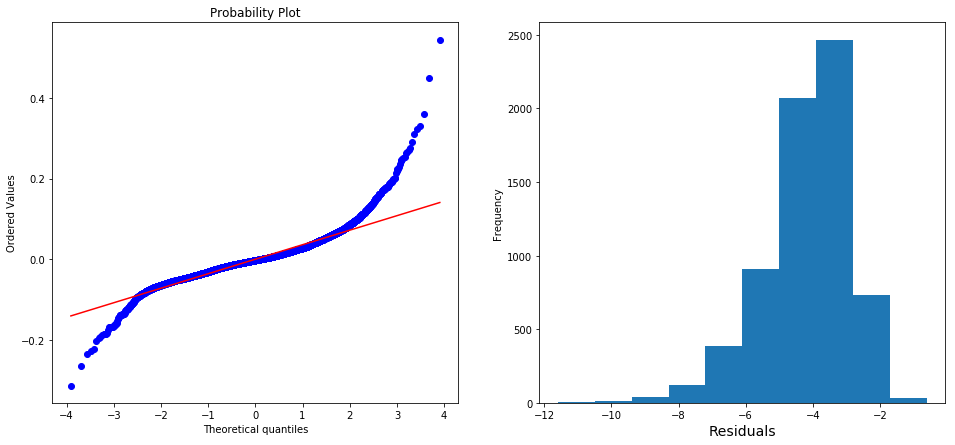

In [ ]:
import math
import statsmodels.formula.api as smf
import scipy as sc
import statsmodels.formula.api as smf
import statsmodels.stats.api as sms
from statsmodels.graphics.regressionplots import plot_leverage_resid2
import matplotlib.pyplot as plt

m1 = smf.ols('Y ~ T1С + T2С + T + Po + P + Pa +'\
       ' U + Ff + ff10 + ff3 + N + W1 + W2 + Tn + Tx + Cl + Nh + H +'\
       ' Cm + Ch + VV + Td + RRR + E + Tg + E1 + sss + WW1 + WW2 +'\
       ' WW3 + WW4 + WW5 + WW6 + veter_vert + veter_horizon + hour + Y_last_hour +'\
       ' dayofweek + month + Y_last_24hour',  data = normalized_X_df)
fitted = m1.fit()
print (fitted.summary())
%pylab inline

plt.figure(figsize(16,7))
plt.subplot(121)
sc.stats.probplot(fitted.resid, dist="norm", plot=pylab)
plt.subplot(122)
np.log(fitted.resid).plot.hist()
plt.xlabel('Residuals', fontsize=14)
pylab.show()

За baseline возьмем R^2 = 0.901

In [ ]:
from sklearn.preprocessing import MinMaxScaler
Y_df  = result[['Y']]
#normalized_X_df.drop(columns=['Y_last_hour'], inplace=True)

result.drop(columns=['Y'], inplace=True)
X = np.array(result)
Y = np.array(Y_df)
print(X.shape, Y.shape)

x_scaler = MinMaxScaler()
X_scaled = x_scaler.fit_transform(X)
y_scaler = MinMaxScaler()
Y_scaled = y_scaler.fit_transform(Y)
Y_scaled += 0.01

(14920, 40) (14920, 1)


In [ ]:
def batch_generator(batch_size, sequence_length, mode):
    """
    Generator function for creating random batches of training-data.
    """

    # Infinite loop.
    while True:
        # Allocate a new array for the batch of input-signals.
        x_shape = (batch_size, sequence_length, num_x_signals)
        x_batch = np.zeros(shape=x_shape, dtype=np.float16)

        # Allocate a new array for the batch of output-signals.
        y_shape = (batch_size, sequence_length, num_y_signals)
        y_batch = np.zeros(shape=y_shape, dtype=np.float16)

        # Fill the batch with random sequences of data.
        for i in range(batch_size):
            # Get a random start-index.
            # This points somewhere into the training-data.
            if mode == 'train':
                idx = np.random.randint(sequence_length+1, num_train)
            else:
                idx = np.random.randint(num_train, num_end)
            # Copy the sequences of data starting at this index.
            x_batch[i] = X_scaled[idx-sequence_length:idx]
            y_batch[i] = Y_scaled[idx-sequence_length:idx]
        
        yield (x_batch, y_batch)

        
sequence_length = 24 * 20
train_batch_size = 1500
test_batch_size = 500
num_x_signals = X.shape[1]
num_y_signals = Y.shape[1]

num_train = int(0.8 * len(X))
num_end = len(X)
train_generator = batch_generator(batch_size=train_batch_size,
                            sequence_length=sequence_length, mode = 'train')
val_generator = batch_generator(batch_size=test_batch_size,
                            sequence_length=sequence_length, mode = 'test')

x_batch, y_batch = next(train_generator)
print(x_batch.shape)
print(y_batch.shape)


validation_data = (np.expand_dims(X_scaled[num_train:], axis=0),
                   np.expand_dims(Y_scaled[num_train:], axis=0))
print(validation_data[0].shape)
print(validation_data[1].shape)

(1500, 480, 40)
(1500, 480, 1)
(1, 2984, 40)
(1, 2984, 1)


In [ ]:
import tensorflow as tf  
import tensorflow.keras.backend as K
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from tensorflow.python.keras.initializers import RandomUniform
from tensorflow.keras.layers import  BatchNormalization


model = tf.keras.models.Sequential()

model.add(tf.keras.layers.LSTM(units=20,
          return_sequences=True,
          input_shape=(None, 40,)))
#model.add(BatchNormalization())
# model.add(tf.keras.layers.LSTM(units = 10, return_sequences = True))
# model.add(BatchNormalization())

# Maybe use lower init-ranges.
init = RandomUniform(minval=-0.05, maxval=0.05)
model.add(tf.keras.layers.Dense(1,
                activation='linear',
                kernel_initializer=init))
model.compile(loss='mean_squared_error', optimizer='adam')#'mean_squared_error'

model.fit_generator(generator=train_generator,
                    epochs = 151,
                    steps_per_epoch=10, 
                    validation_data = val_generator,
                    validation_steps=1)


C:\Users\user_PC\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\user_PC\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\user_PC\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\user_PC\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:529: FutureWarnin

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Use tf.cast instead.
Epoch 1/151
10/10 [==============================] - 25s 3s/step - loss: 0.0280 - val_loss: 0.0314
Epoch 2/151
10/10 [==============================] - 23s 2s/step - loss: 0.0121 - val_loss: 0.0245
Epoch 3/151
10/10 [==============================] - 23s 2s/step - loss: 0.0114 - val_loss: 0.0243
Epoch 4/151
10/10 [==============================] - 22s 2s/step - loss: 0.0106 - val_loss: 0.0269
Epoch 5/151
10/10 [==============================] - 21s 2s/step - loss: 0.0102 - val_loss: 0.0248
Epoch 6/151
10/10 [==============================] - 22s 2s/step - loss: 0.0100 - val_loss: 0.0250
Epoch 7/151
10/10 [==============================] - 22s 2s/step - loss: 0.0097 - val_loss: 0.0254
Epoch 8/151
10/10 [==============================] - 24s 2s/step - loss: 0.0095 - val_loss: 0.0236
Epoch 9/151
10/10 [=====================

In [ ]:
def var_importance(model, df):
    
    x = validation_data[0]
    orig_out = model.predict(x)
    feature_name_list = df.columns.tolist()
    feature_importance = []
    for i in range(X.shape[1]):  # iterate over the  features
        new_x = x.copy()
        perturbation = np.random.normal(0.0, 0.2, size=new_x.shape[:2])
        new_x[:, :, i] = new_x[:, :, i] + perturbation
        perturbed_out = model.predict(new_x)
        effect = ((orig_out - perturbed_out) ** 2).mean() ** 0.5
        print(f' {feature_name_list[i]},      feature importance:      {effect:.4f}')
        feature_importance += [effect]
    return(zip(feature_name_list, feature_importance))   


feature_imp_zip_list = var_importance(model, result)  

In [ ]:
feature_imp_zip_list = list(sorted(feature_imp_zip_list, key=lambda x: x[1]))
df = pd.DataFrame(feature_imp_zip_list, columns=['word', 'frequency'])
df.plot(kind='bar', x='word')

In [ ]:
actual_val = np.array(Y[num_train:])
y_pred = model.predict(validation_data[0])
y_pred_rescaled = y_scaler.inverse_transform(y_pred.reshape(1, y_pred.shape[1]))


pred_val = np.ravel(y_pred_rescaled)
actual_val = np.ravel(actual_val)
#actual_val = np.ravel(validation_data[1][0])
#errors = (np.ravel(validation_data[1][0]) - np.ravel(y_pred_rescaled))
errors = (actual_val - pred_val)

In [ ]:
import scipy.stats as stats
# print(errors_list)
# print(actual_val, pred_val)
print('weighted by mean std error = {}'.format(np.mean(errors)/np.mean(actual_val)))

lines = plt.plot(list(range(len(errors))), actual_val, list(range(len(errors))), pred_val)
l1, l2= lines
plt.setp(lines, linestyle='-')
plt.setp(l1, linewidth=1, color='b')
plt.setp(l2, linewidth=1, color='r')
plt.title('actual - b, pred - r тестовая выборка' )
plt.grid()
plt.show()
plt.pause(0.05)

lines = plt.plot(list(range(len(errors)))[2100:], actual_val[2100:], list(range(len(errors)))[2100:], pred_val[2100:])
l1, l2= lines
plt.setp(lines, linestyle='-')
plt.setp(l1, linewidth=1, color='b')
plt.setp(l2, linewidth=1, color='r')
plt.title('actual - b, pred - r  тестовая выборка(лето)' )
plt.grid()
plt.show()
plt.pause(0.05)

lines = plt.plot(list(range(len(errors))), errors/np.mean(actual_val))
l1= lines
plt.setp(lines, linestyle='-')
plt.setp(l1, linewidth=1, color='b')
plt.title('относительная ошибка' )
plt.grid()
plt.show()
plt.pause(0.05)

lines = plt.scatter(actual_val[:2100], pred_val[:2100])
plt.xlabel("actual_val")
plt.ylabel("pred_val")
plt.grid()
plt.show()
plt.pause(0.05)

slope, intercept, r_value, p_value, std_err = stats.linregress(actual_val[:2100], pred_val[:2100])
print('R**2 = {}'.format(r_value**2)) 

лето второго года предсказывается плохо (реальный расход днем выше)). посмотрим на нормальность распределения ошибки в этих двух интервалах. R^2 превосходит baseline линейной интерполяции параметров (0,936 vs 0.841)

In [ ]:
import seaborn as sns

sns.distplot(errors[:2100])
plt.pause(0.05)
stats.probplot(errors[:2100], dist="norm", plot=pylab)
pylab.show()

In [ ]:
sns.distplot(errors[2100:])
plt.pause(0.05)
stats.probplot(errors[2100:], dist="norm", plot=pylab)
pylab.show()